In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import pandas as pd
import pandas_datareader.fred as fred
import numpy as np

from src.plotting import plot_dfs, all_equal
from src.process_data import get_fred_data, ser_adf, get_seasonal_hp
from src.classes import PolyDetrend
from src.utils import apply_func

import seaborn as sns

import datetime as dt

Load data

In [43]:
from config import fred_dict2
for item in fred_dict2.items():
    print(f'{item[0]},   contains:    {item[1][1]}')

Y,   contains:    Gross Domestic Product
pi_s,   contains:    Sticky Price Consumer Price Index less Food and Energy
pi_c,   contains:    Median Consumer Price Index (core inflation)
r,   contains:    Federal Funds Effective Rate
I,   contains:    Gross Private Domestic Investment
C,   contains:    Personal Consumption Expenditures Excluding Food and Energy
Ix,   contains:    Imports of Goods and Services
Zx,   contains:    Exports of Goods and Services
L,   contains:    Nonfarm Business Sector: Hours Worked for All Workers
w,   contains:    Average Hourly Earnings of All Employees, Total Private
defl,   contains:    Gross Domestic Product: Implicit Price Deflator
recs,   contains:    GDP-Based Recession Indicator Index


In [4]:
from config import recession_dict
df_all = pd.read_csv(os.path.join(DATA_DIR, 'raw_data.csv'), index_col='date').drop('Unnamed: 0', axis=1)
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.asfreq('QS')

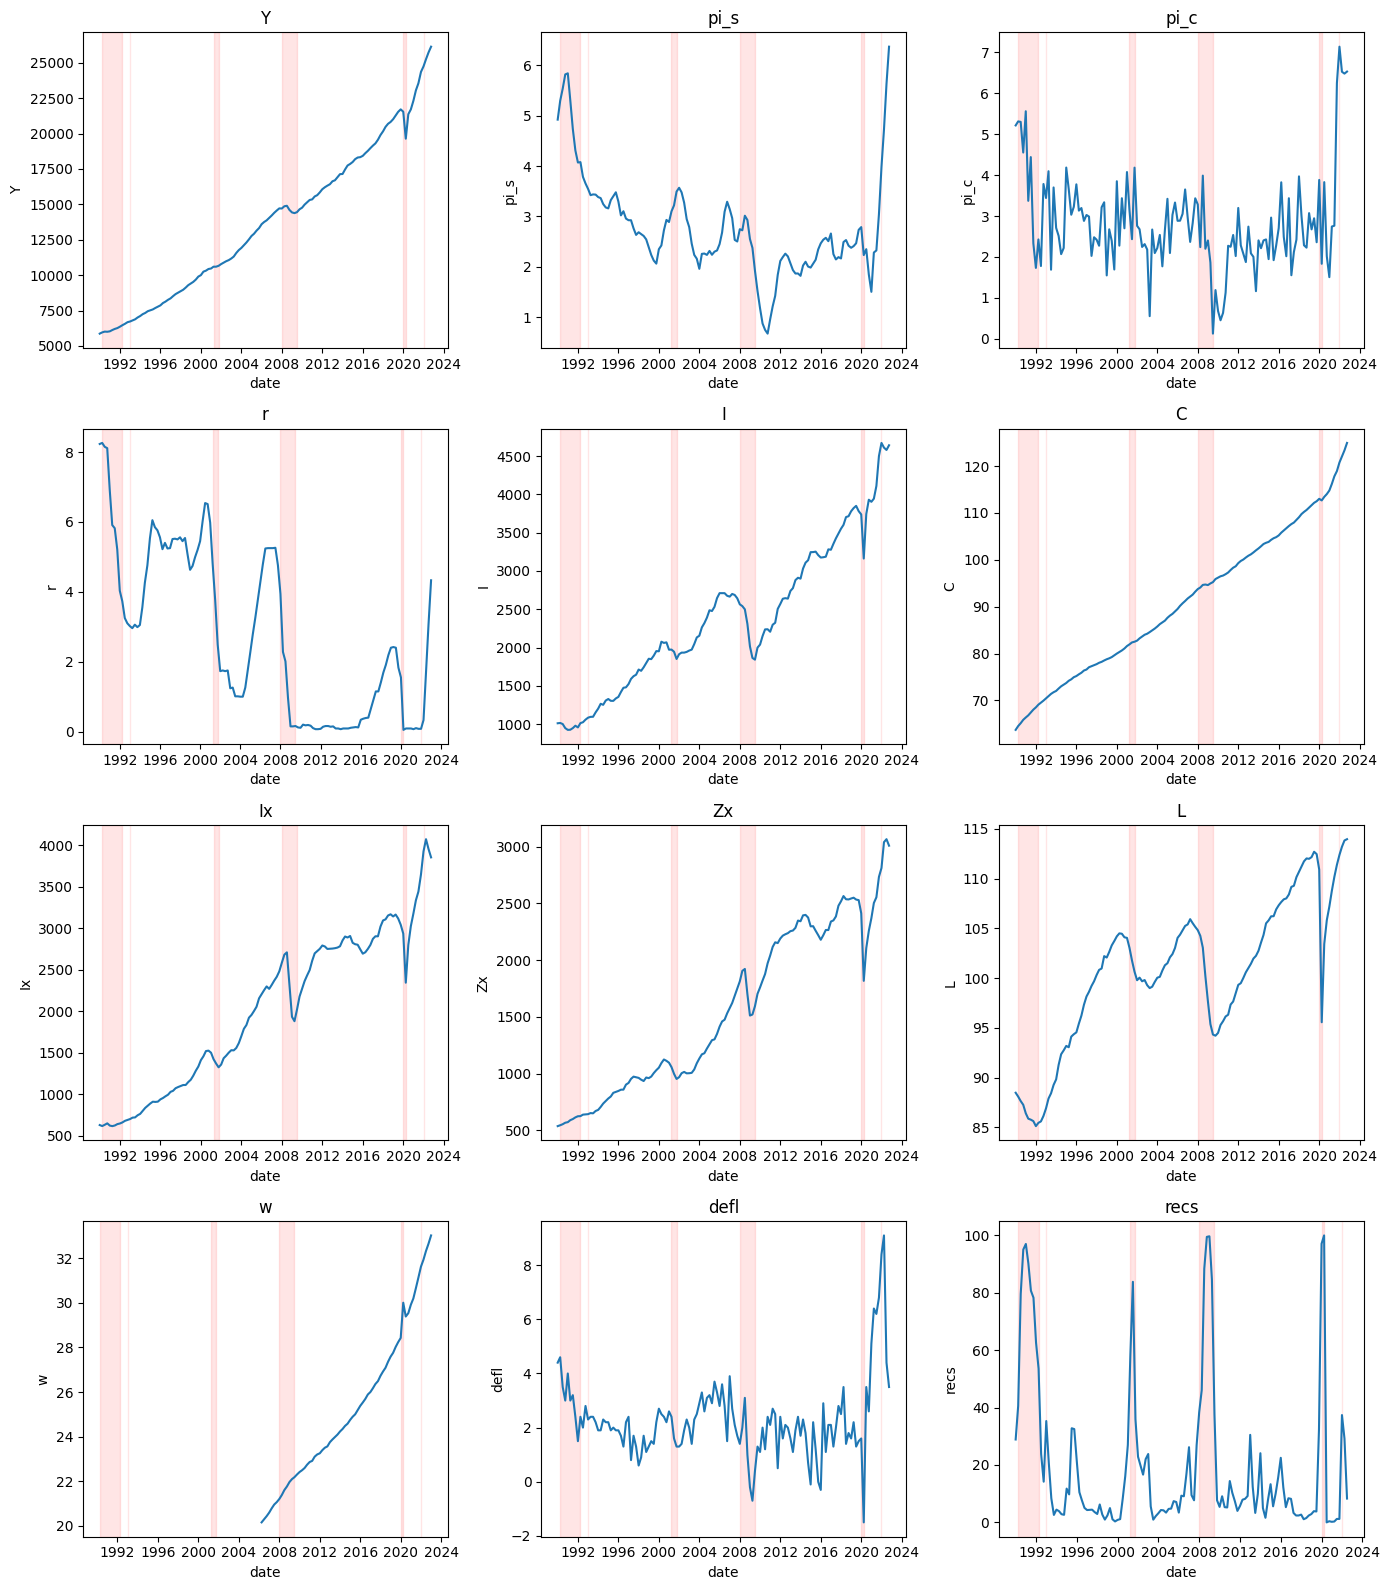

In [5]:
plot_dfs(df_all, sns.lineplot, fill_arr=recession_dict)

work data

In [6]:
df = df_all.dropna().copy()
df.drop(['recs', 'defl'], axis=1, inplace=True)

# sample period
print(f'sample starts: {df.index[0].date()} \nsample ends: {df.index[-1].date()}')

# check for missing intra sample data
pd.DataFrame(df.index - df.index.shift(-1)).describe()

sample starts: 2006-04-01 
sample ends: 2022-07-01


,date
count,66
mean,91 days 06:54:32.727272727
std,0 days 18:42:58.623739751
min,90 days 00:00:00
25%,91 days 00:00:00
50%,91 days 00:00:00
75%,92 days 00:00:00
max,92 days 00:00:00


In [7]:
# train test split
test_size = .2
test_ind = df.iloc[-round(len(df) * test_size):,:].index
train_ind = df.iloc[:-round(len(df) * test_size),:].index

In [8]:
print(f'test size is: {test_size * 100}%, corresponding to {len(test_ind)} lines')
print(f'time between train & test: {(train_ind[-1] - test_ind[0])}')

test size is: 20.0%, corresponding to 13 lines
time between train & test: -91 days +00:00:00


log trans

In [9]:
non_neg = [col for col in df.columns if min(df[col]) > 0]
print(f'All cols non-negative: {all_equal([non_neg, list(df.columns)])}')
for col in non_neg:
    df[col] = apply_func(df[col], np.log)

All cols non-negative: True


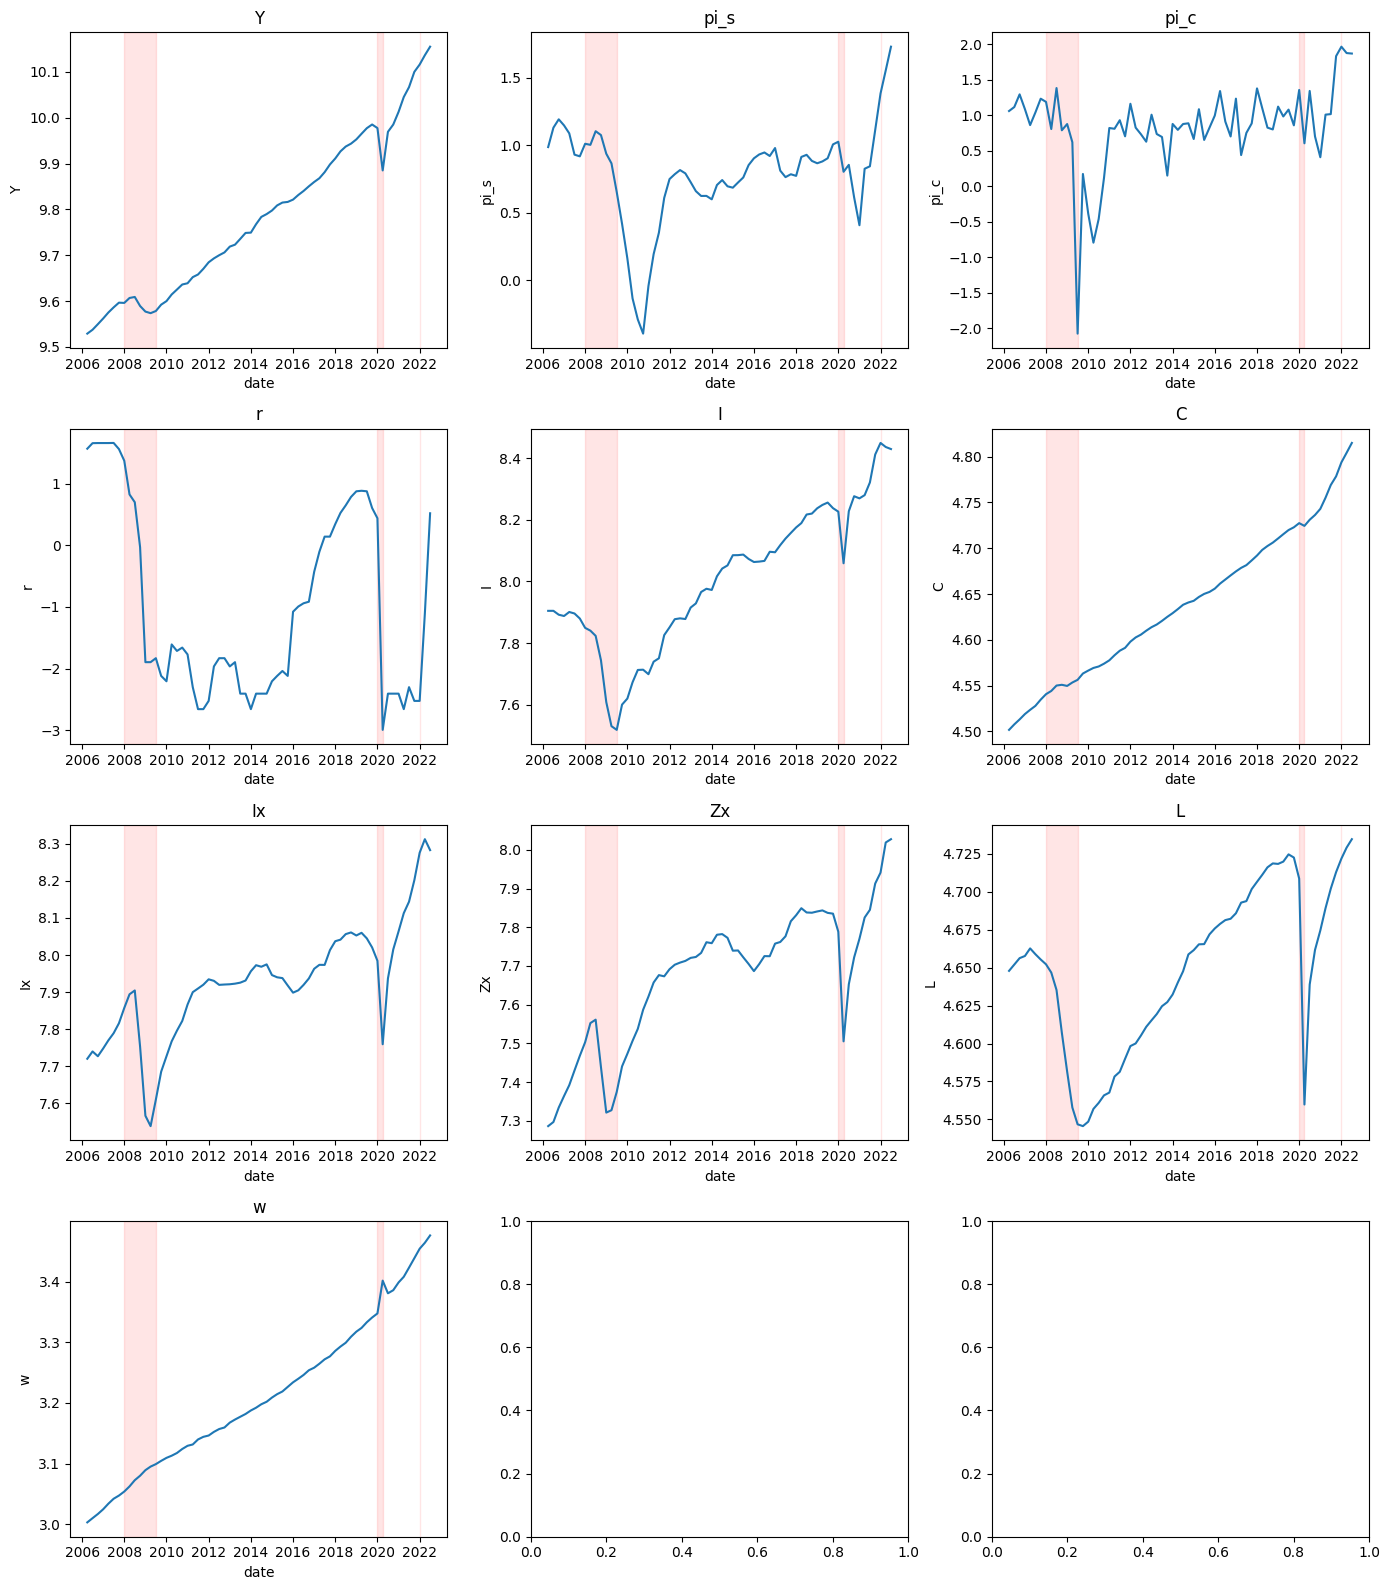

In [10]:
plot_dfs(df, sns.lineplot, fill_arr=recession_dict)

test stationarity

In [11]:
# for col in df.columns:
#     ser_adf(df.loc[train_ind, col])

polynomial detrend

In [44]:
df_1 = df.copy()
df_2 = df.copy()

In [13]:
# poly detrend
detrend_cols = ["Y", "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    _train = df_1.loc[train_ind, col].copy()
    _det = PolyDetrend(_train, 2)
    df_1.loc[train_ind, col] = _det.get_detrend()
    
    _test = df_1.loc[test_ind, col].copy()
    df_1.loc[test_ind, col] = _det.predict_detrend(_test)

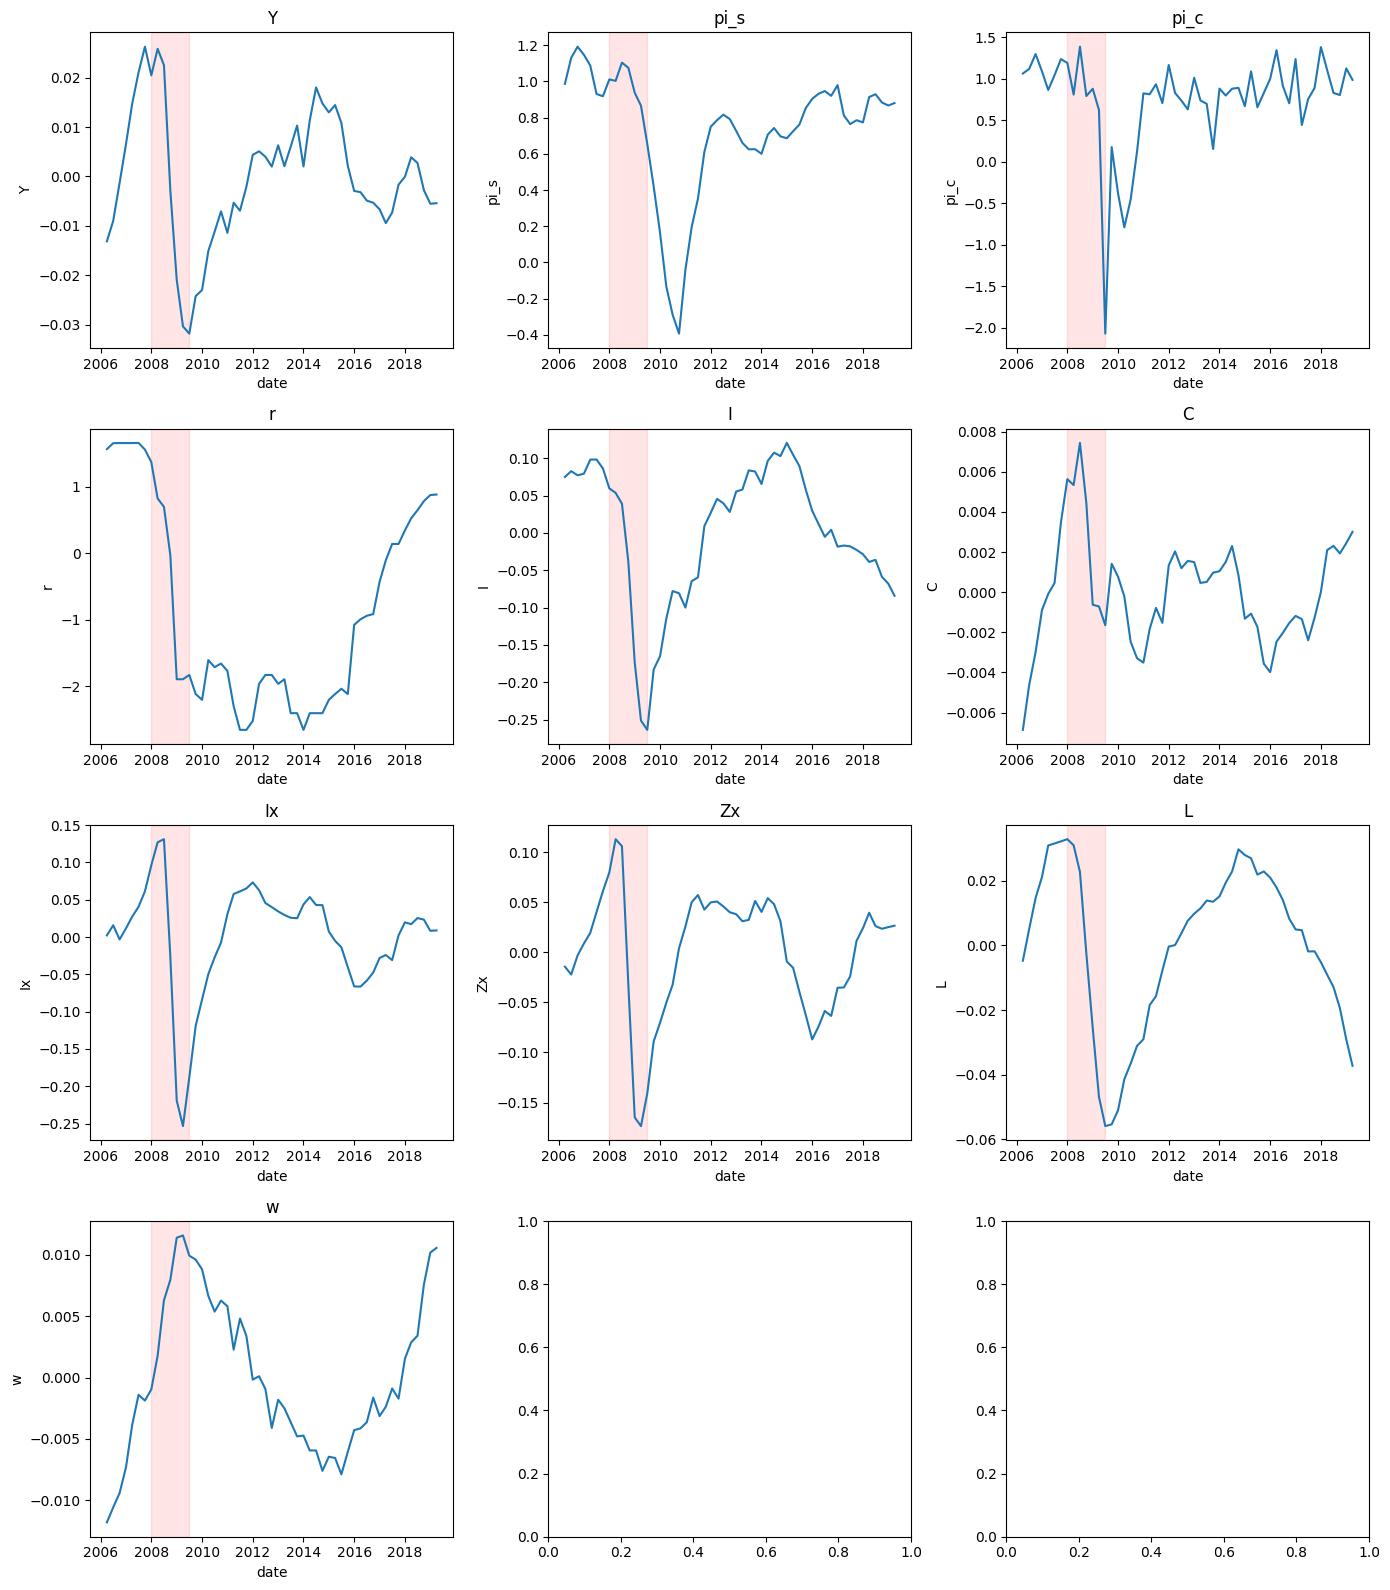

In [14]:
plot_dfs(df_1.loc[train_ind], sns.lineplot, fill_arr=recession_dict)

In [ ]:
# diff or diff_log

In [46]:
# hp detrend
detrend_cols = ["Y", "I", "C", "L", "Ix", "Zx", "w"]
for col in detrend_cols:
    _ser = df_2[col].copy()
    _cyc, _det = get_seasonal_hp(_ser, lamb=1600.0)
    df_2[col] = _cyc
    df_2[f'{col}_trend'] = _det

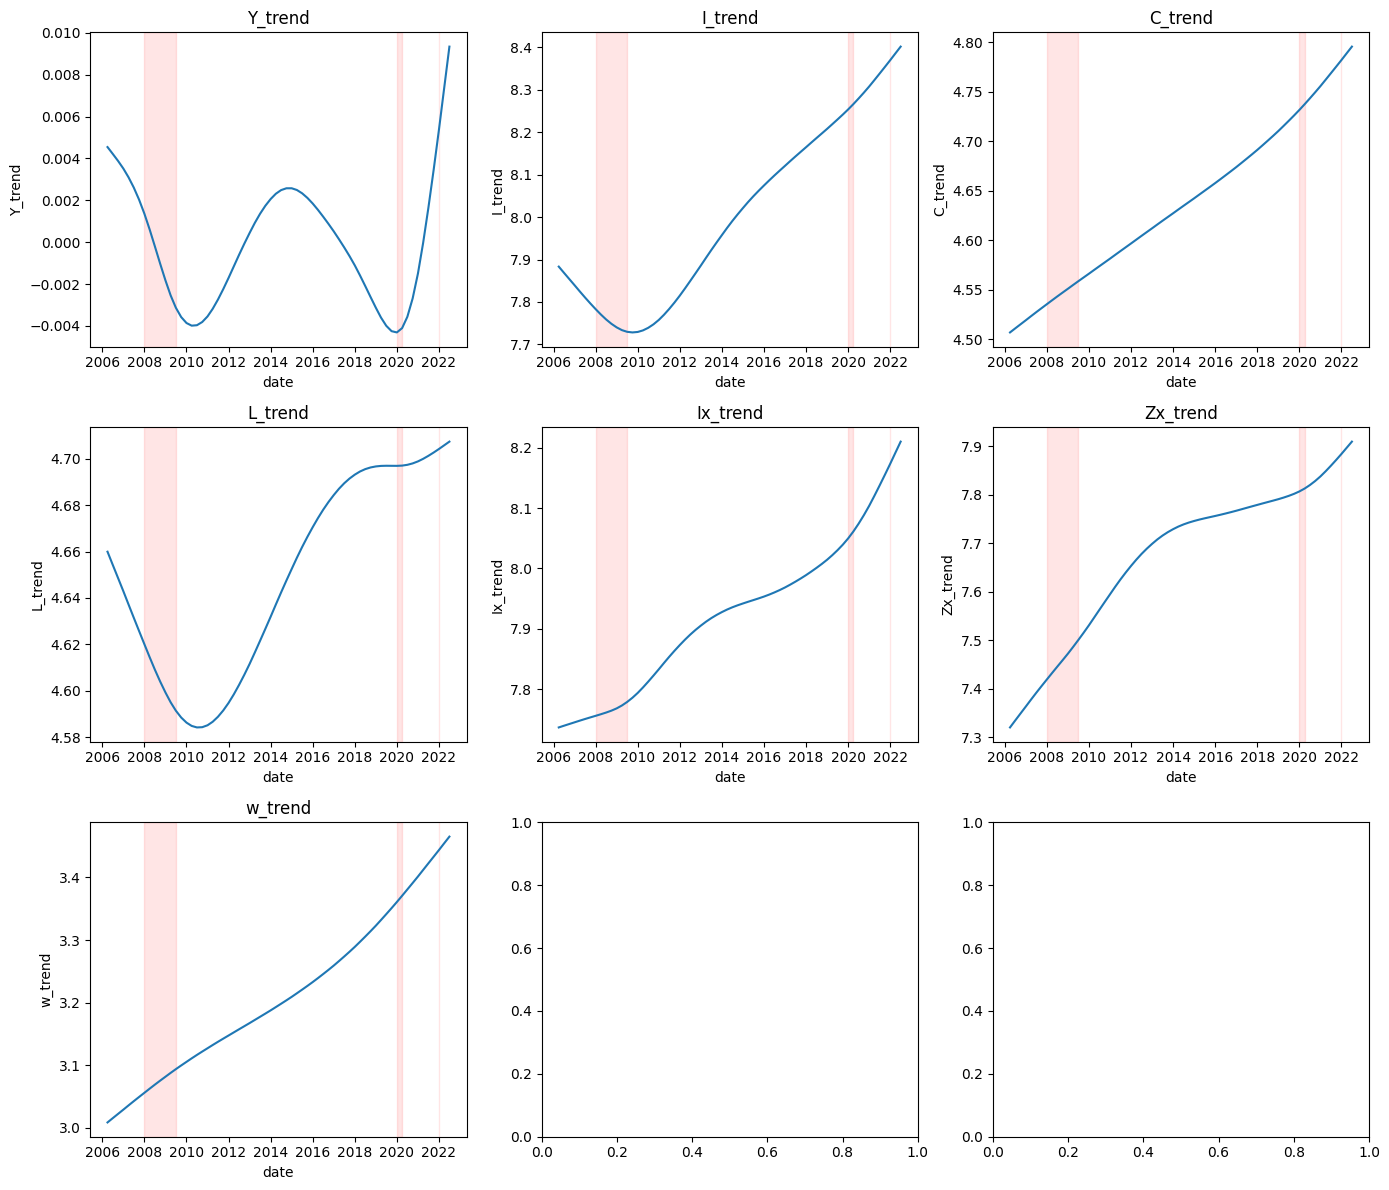

In [48]:
plot_dfs(df_2[[item for item in df_2.columns if 'trend' in item]], sns.lineplot, fill_arr=recession_dict)

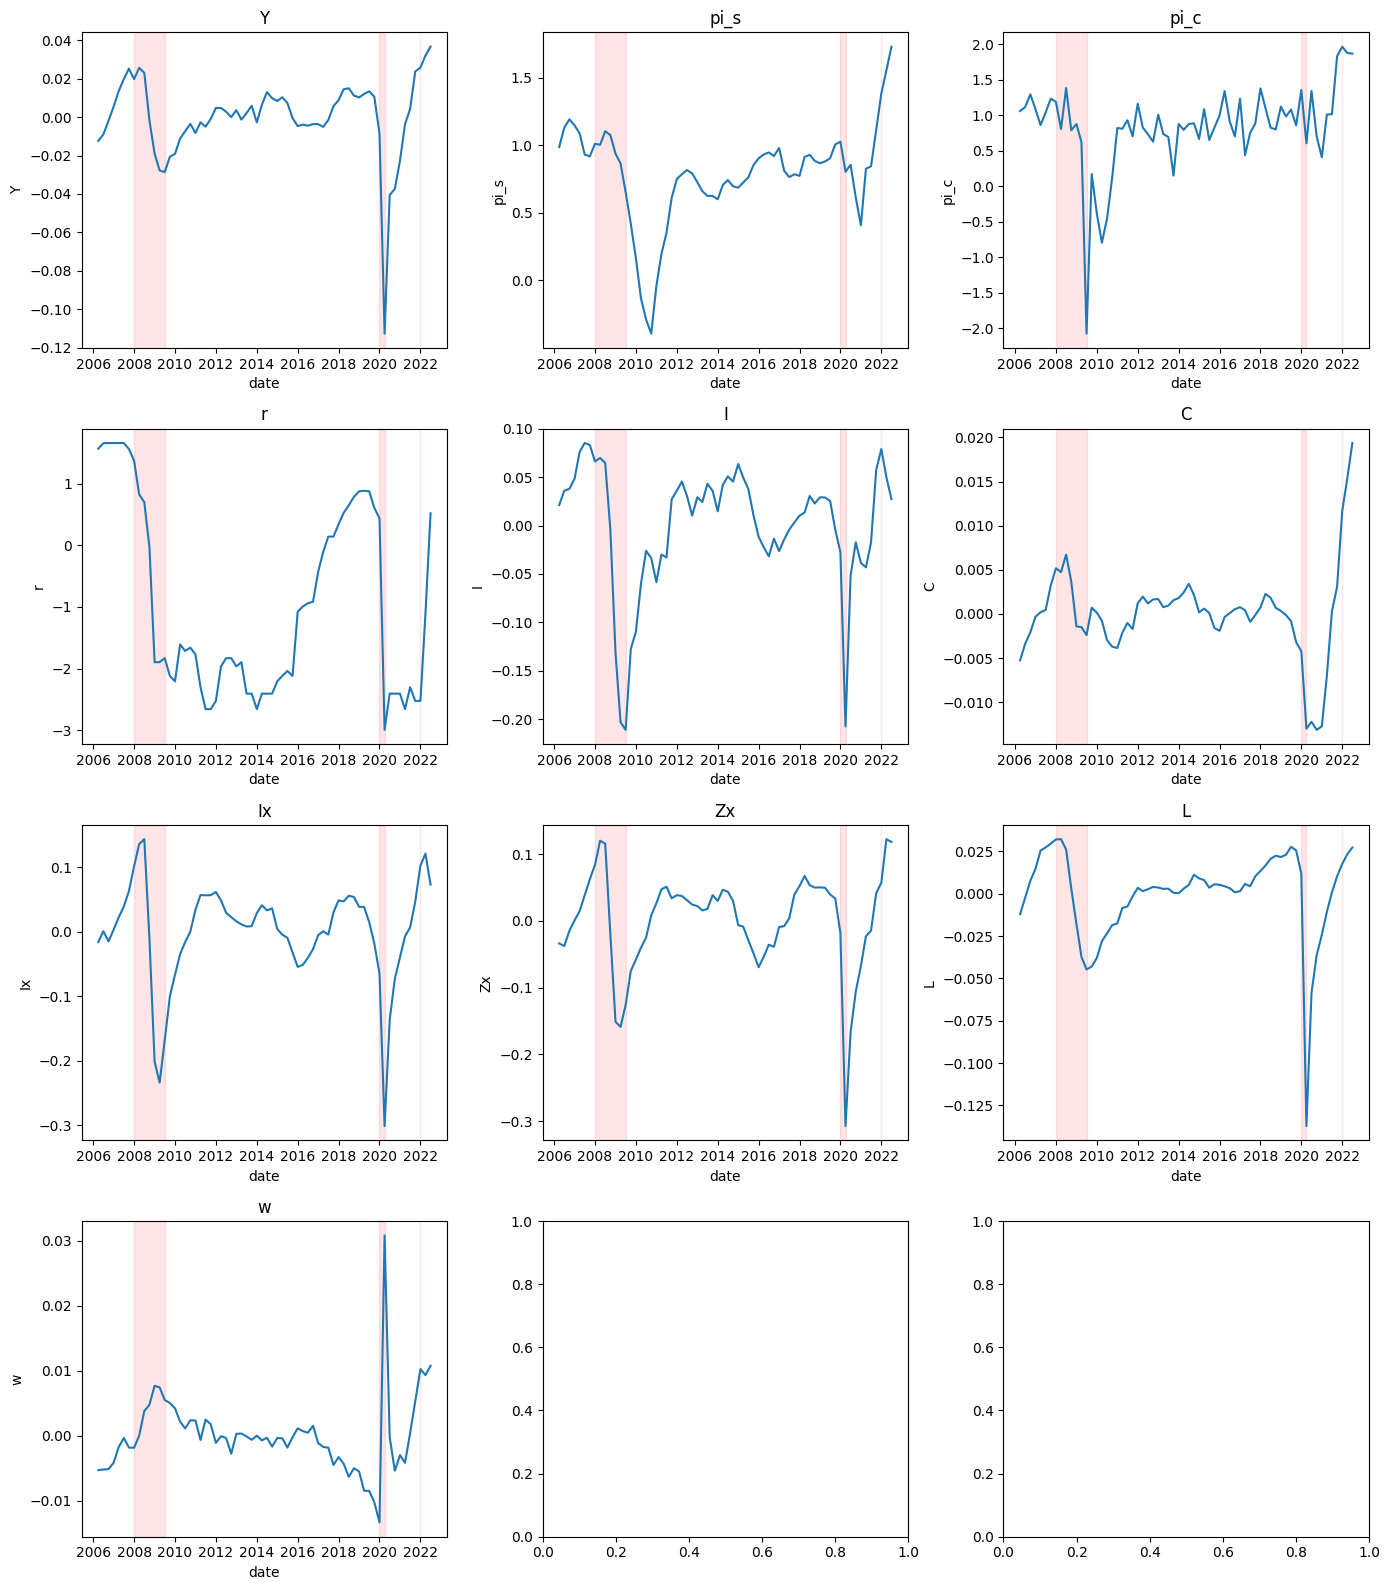

In [16]:
plot_dfs(df_2, sns.lineplot, fill_arr=recession_dict)

stationarity

In [17]:
# train data poly detrend
for col in df_1.columns:
    ser_adf(df_1.loc[train_ind, col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 0.031740088906301395,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.01623348733104535,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0639695637774434,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.48837889246593846,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.14846523782728854,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 0.021584976612222445,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Ix --------------------
 p-val: 0.030492038019658874,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit ro

In [18]:
# train data hp filter
for col in df_2.columns:
    ser_adf(df_2.loc[train_ind, col])

Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Y --------------------
 p-val: 0.024649307559551963,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_s --------------------
 p-val: 0.01623348733104535,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- pi_c --------------------
 p-val: 0.0639695637774434,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- r --------------------
 p-val: 0.48837889246593846,  reject: False


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- I --------------------
 p-val: 0.02588834880251321,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- C --------------------
 p-val: 0.006301429272565682,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit root
-------------------- Ix --------------------
 p-val: 0.016605049900475115,  reject: True


Augmented Dickey-Fuller Test: H0 -> unit roo

In [19]:
# using the HP filter due to better enforcement of statiornarity

save data

In [20]:
df_2['is_test'] = list([False] * len(df_2))
df_2.loc[test_ind, 'is_test'] = list([True] * len(test_ind))

In [21]:
df_2.reset_index(names='date').to_csv(os.path.join(DATA_DIR, 'prepro_data.csv'))